In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import datasets
from regression import OnlineGradientDescent, CoinBetting, DimensionFreeExponentiatedGradient, AdaptiveNormal

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reproducing (Orabona and Pal, 2016)

In [45]:
data = datasets.CpuSmall(root='../', standardize=False, normalize=True)  # default preprocessing used in (Orabona and Pal, 2016)

In [46]:
ogds = dict()
lr_scales = np.array([1.5 ** n for n in range(20)])
for lr_scale in lr_scales:
    ogds[lr_scale] = OnlineGradientDescent(lr_scale=lr_scale).fit(data.X, data.y)

In [47]:
dfeg = DimensionFreeExponentiatedGradient().fit(data.X, data.y)
adanorm = AdaptiveNormal().fit(data.X, data.y)
coin = CoinBetting(init_wealth=100).fit(data.X, data.y)

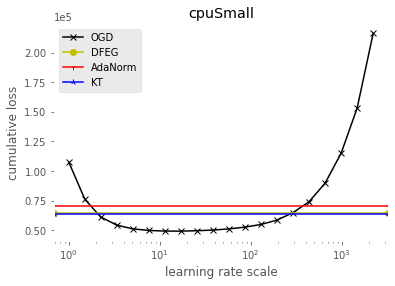

In [48]:
plt.semilogx(lr_scales, [ogds[lr_scale].cumulative_loss for lr_scale in lr_scales], color='k', marker='x', label='OGD')
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.xlabel('learning rate scale')
plt.ylabel('cumulative loss')
plt.title('')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

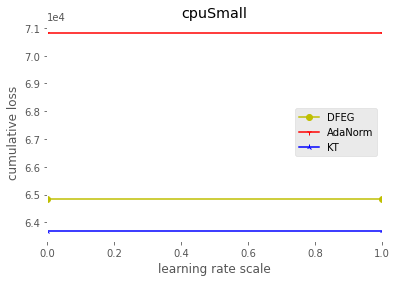

In [49]:
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.xlabel('learning rate scale')
plt.ylabel('cumulative loss')
plt.title('')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

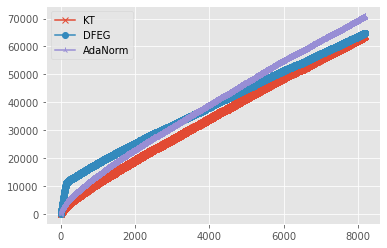

In [50]:
plt.plot(coin.losses.cumsum(), 'x-', label='KT')
plt.plot(dfeg.losses.cumsum(), 'o-', label='DFEG')
plt.plot(adanorm.losses.cumsum(), '2-', label='AdaNorm')
plt.legend()
